In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset import EM_DATA
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
from IPython.display import Image as IPImage
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
%matplotlib inline

## Making a dataloader
First step is to create a dataloader and to check if the dataset we created in dataset.py works as planned. 
Another thing that should be noted as I also mention in the dataset is that our defined transformation should end with a to_tensor with the way i structured the dataset

In [2]:
# Non random transformations. The random transformations should be added in the dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
train_dataset = EM_DATA(train=True, size=256, _transform=transform, data_path="EM_ISBI_Challenge")
test_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="EM_ISBI_Challenge")

# Determine a batch size
BATCH_SIZE = 2

# Define pytorch data loaders
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

### Test dataloader
Now with the dataloader defined lets investigate it a bit. The dataloaders are generators which is why we can call next on it

In [3]:
train_image, train_mask = next(iter(train_loader))
test_image, test_mask = next(iter(test_loader))

# See the shapes
print(train_image.shape, train_mask.shape)
print(test_image.shape, test_mask.shape)

torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256])
torch.Size([2, 3, 256, 256]) torch.Size([2, 256])


As you see from the shapes we now have the images in the formats we want i.e. (batch_size, channels, height, width).
Note that we get a mask for the testset even though it doesn't exist but that is just to make the implementation easier.
Now lets visualize an image

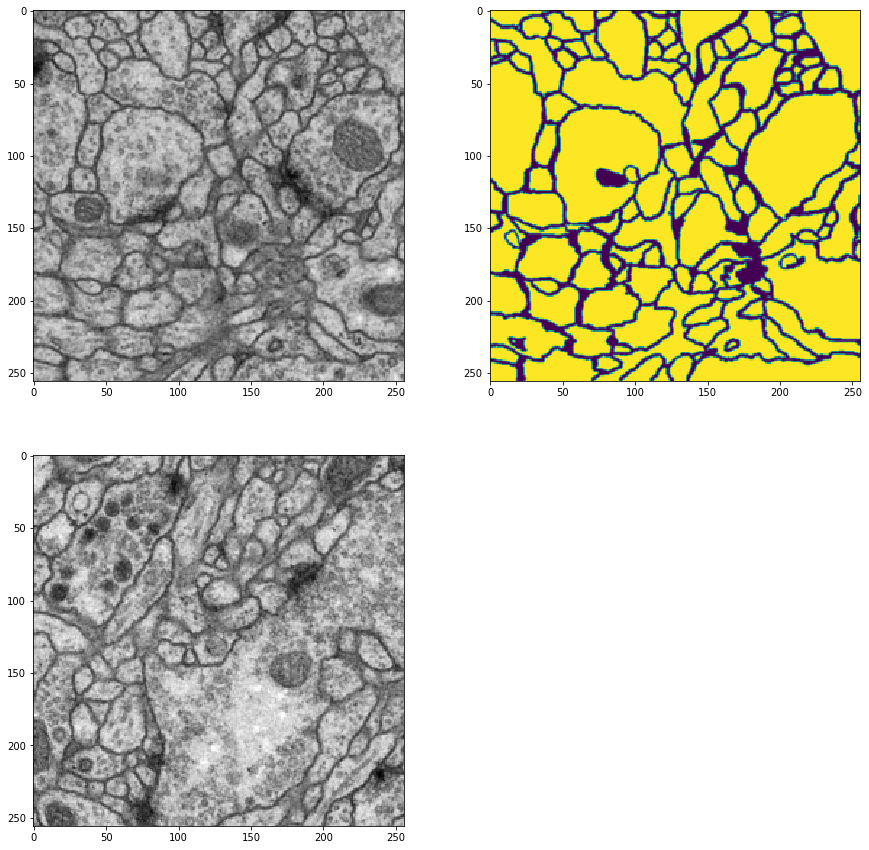

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(train_image[0, ...].permute(1,2,0).squeeze())
plt.subplot(2,2,2)
plt.imshow(train_mask[0, ...].permute(1,2,0).squeeze())
plt.subplot(2,2,3)
plt.imshow(test_image[0, ...].permute(1,2,0).squeeze())
plt.show()

Notice how i permute the data since we have (batch_size, channels, height, width) and matplotlib needs the channels to be in the end

# Defining the training loop
Below I'll provide a really basic training loop you can use, but you can improve it however you want

In [5]:
def train(model, opt, loss_fn, epochs, data_loader, print_status):
    """
    Very simple training function you can use at a starting point
    :param model: Pytorch model that inherits from torch.nn.Module
    :param opt: torch.optim optimizer
    :param loss_fn: loss function
    :param epochs: amount of epochs to train
    :param data_loader: A torch.utils.data.DataLoader object
    """
    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        model.train()  # Set the model to train mode. This will enable dropout and so on if implemented
        for X_batch, Y_batch in data_loader:
            
            # The next to lines allows the model to run on the gpu if cuda is available
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward pass
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # compute loss
            loss.backward()  # backward-pass to compute gradients
            opt.step()  # update weights

            # Compute average epoch loss
            avg_loss += loss / len(data_loader)
        
        if print_status:
            print(f"Loss in epoch {epoch} was {avg_loss}")

# Defining the loss and optimizer
As we can see from the training loop we still need to define the optimizer, model and the loss function. For the loss function I've provided a simple binary cross entropy implementation. 

In [6]:
def bce_loss(y_real, y_pred):
    """
    Simple binary cross entropy loss
    :param y_real: target value (label)
    :param y_pred: predicted value
    :return: loss 
    """
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

# Defining the model
This is where you really should show you skills and create an awesome model to use! Below is my implementation of a UNet model you can use as a starting point. The Image below is the original UNet structure and not the exact same as mine, so it is just here to get an idea about the structure

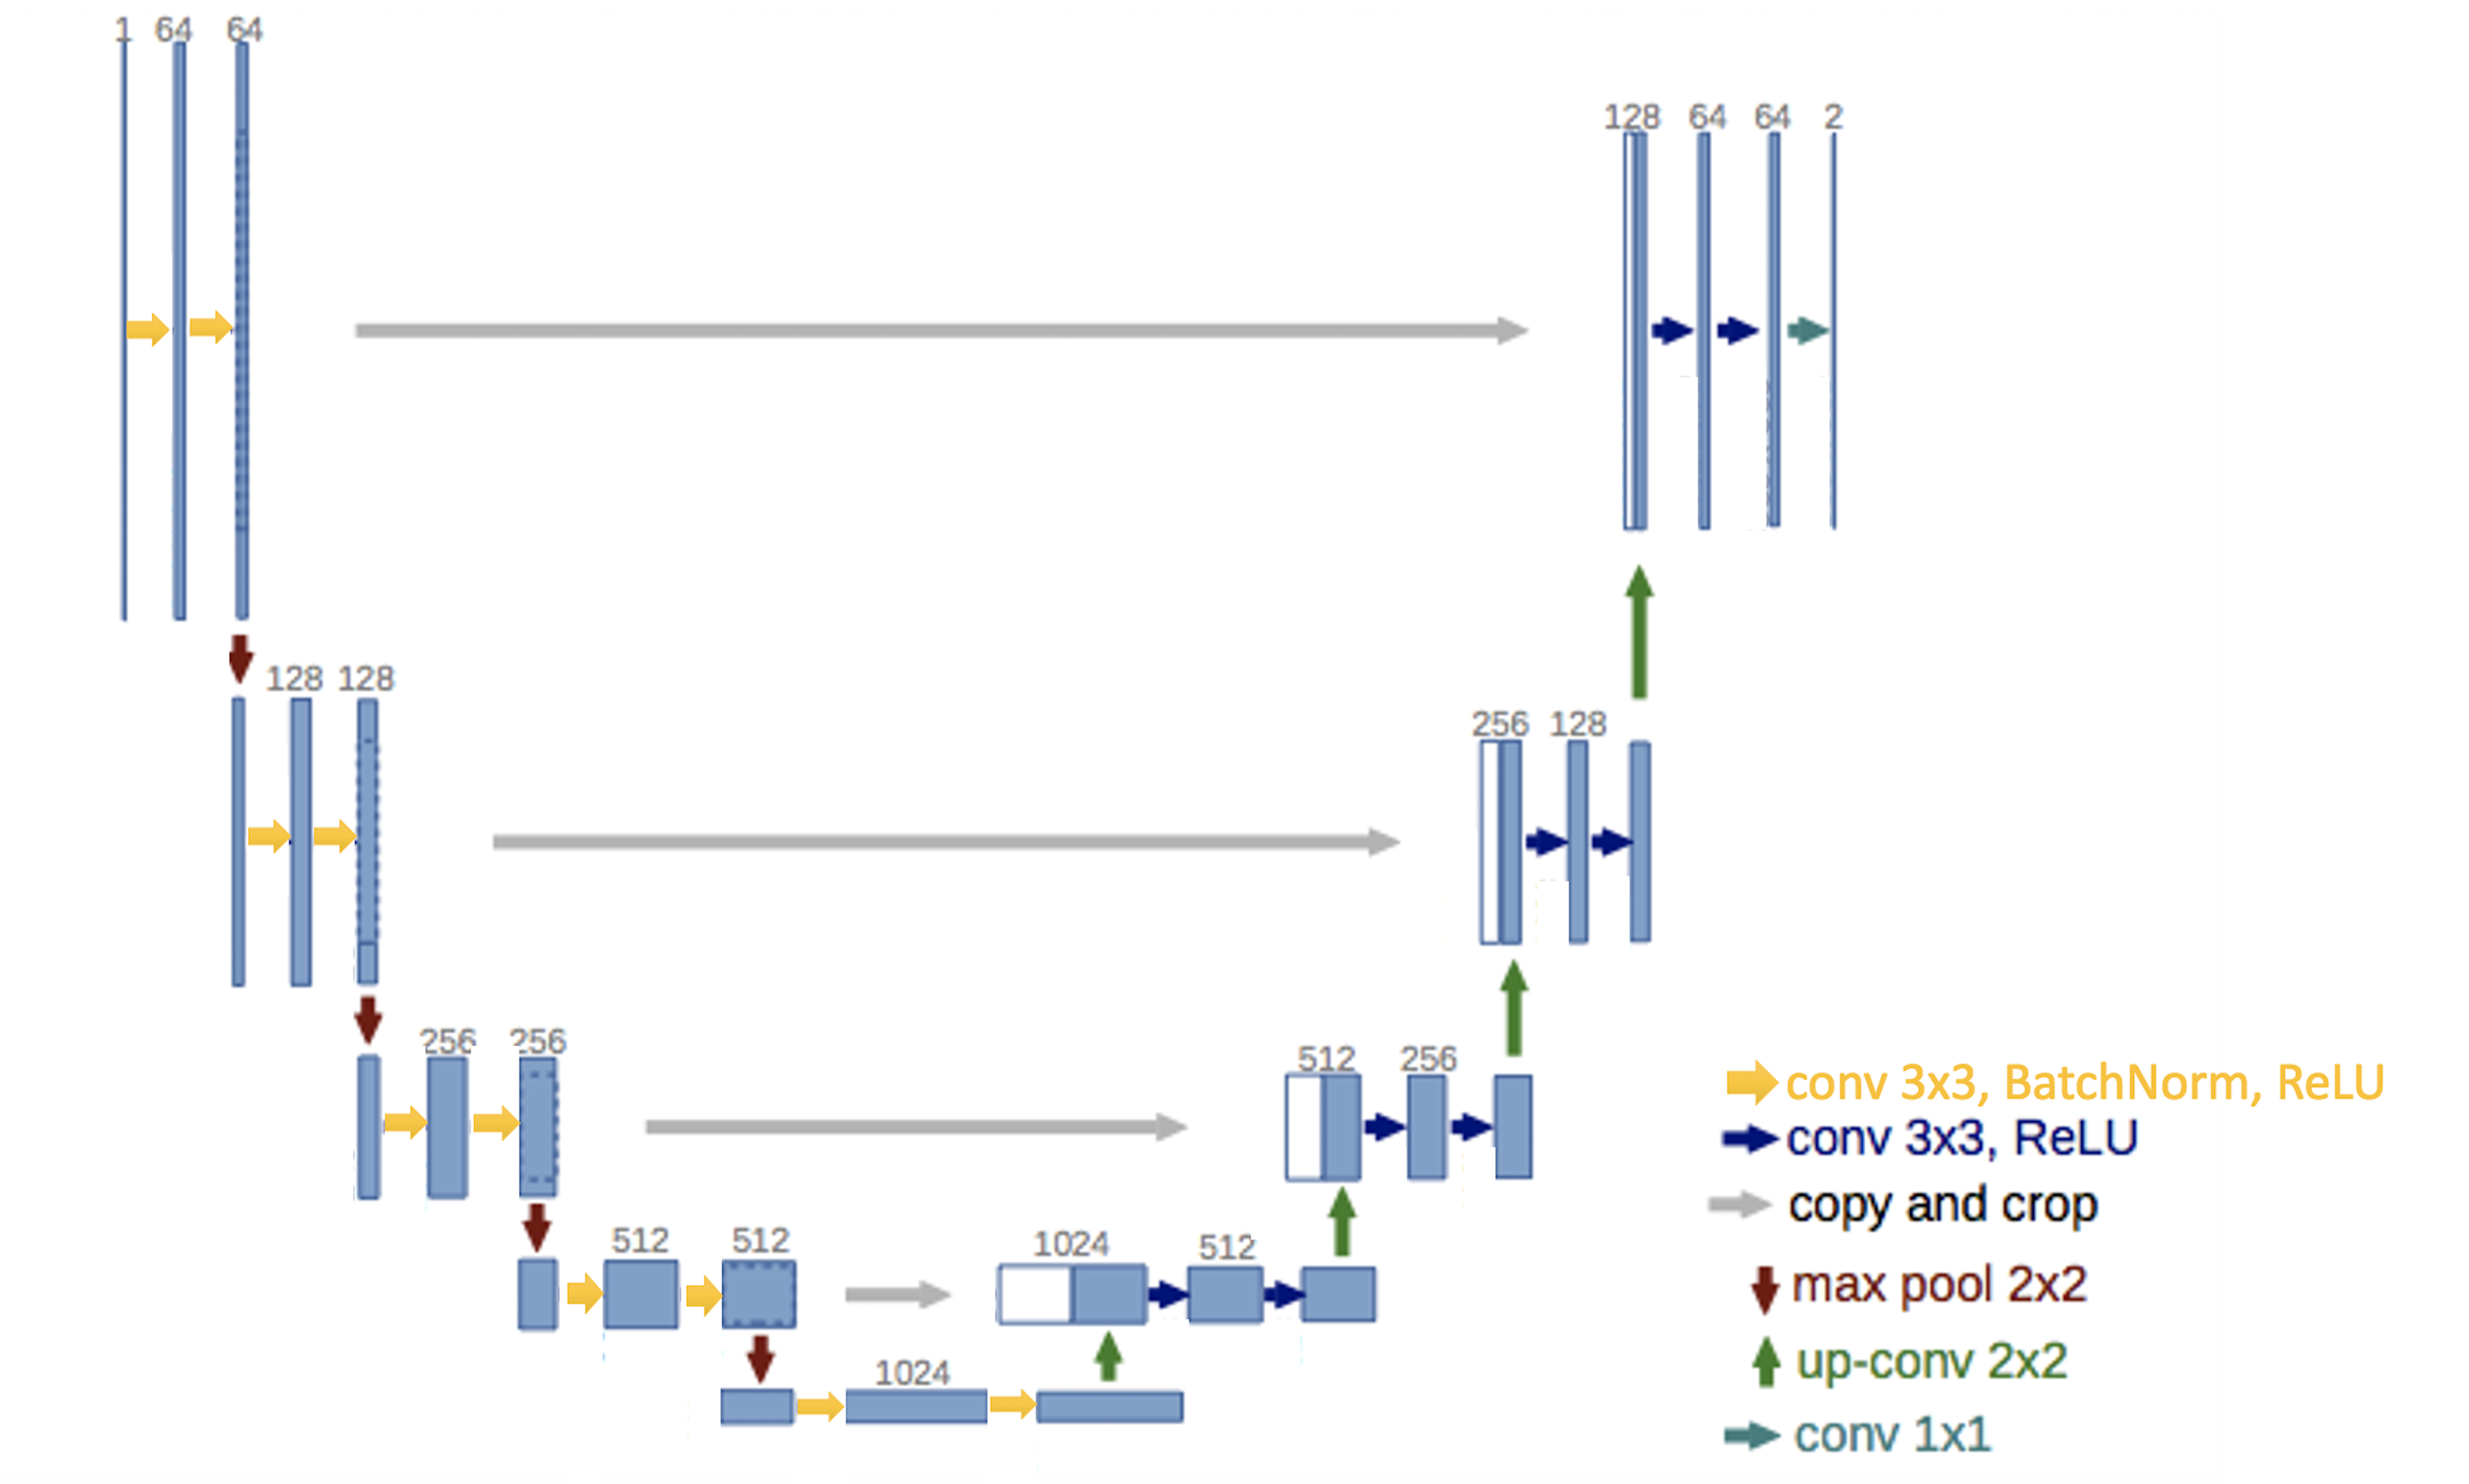

In [7]:
IPImage("unet1.png")

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))
        

        # decoder
        skip0 = torch.cat([self.upsample0(b), F.relu(self.enc_conv3(e2))], 1)
        d0 = F.relu(self.dec_conv0(skip0))
        skip1 = torch.cat([self.upsample1(d0), F.relu(self.enc_conv2(e1))], 1)
        d1 = F.relu(self.dec_conv1(skip1))
        skip2 = torch.cat([self.upsample2(d1), F.relu(self.enc_conv1(e0))], 1)
        d2 = F.relu(self.dec_conv2(skip2))
        skip3 = torch.cat([self.upsample3(d2), F.relu(self.enc_conv0(x))], 1)
        d3 = self.dec_conv3(skip3)  # no activation
        return d3

# Putting it all together
Now all we need is to define the optimizer and put it all together

In [9]:
# First lets check if an GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Next creat an instance of the UNet model
model = UNet().to(device)

# Now define the optimizer
optimizer = optim.Adam(model.parameters())

# And finally lets train the model
train(model, optimizer, bce_loss, 10, train_loader, print_status=True)

Loss in epoch 0 was 0.5261548757553101
Loss in epoch 1 was 0.4631483554840088
Loss in epoch 2 was 0.4302949607372284
Loss in epoch 3 was 0.38471266627311707
Loss in epoch 4 was 0.3396967649459839
Loss in epoch 5 was 0.32218435406684875
Loss in epoch 6 was 0.3185427188873291
Loss in epoch 7 was 0.30564701557159424
Loss in epoch 8 was 0.31070780754089355
Loss in epoch 9 was 0.3044583201408386



# Lets see the results!
Now we are ready to check the performance of the model! We didn't train it for very long so we dont expect perfect results! Note that I apply the sigmoid to the output here and not in the model. I could however also have included it into the model it self.

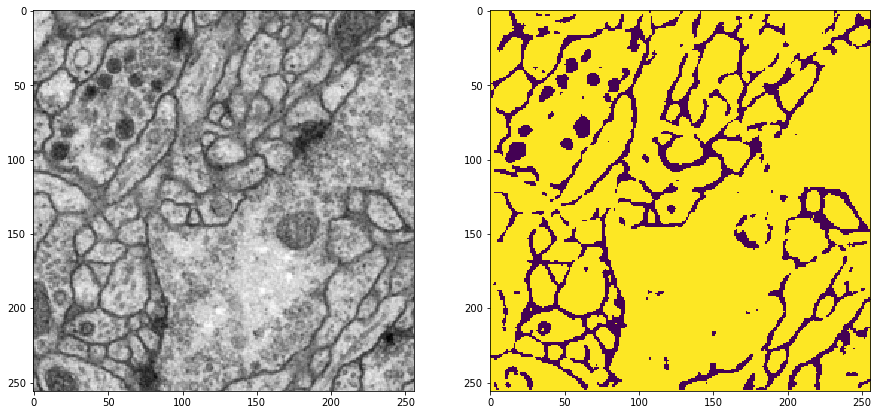

In [10]:
predim = model(test_dataset[0][0].unsqueeze(0).to(device))
prob_im = np.asarray(torch.sigmoid(predim).detach().cpu().squeeze())
    
# Binarize
pred = prob_im > 0.5

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[0][0].permute(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.show()